# QEC with the Shor Code
Implements Shor's Algorithm and demostrates improved error rates in simulations

In [1]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

## Assemble Fault-Tolerant and Non-Fault-Tolerant Circuits

* We will flip the qubit (apply a NOT gate, otherwise known as an X gate) a certain number of times
* TODO: expand to random clifford circuits

In [2]:
def add_rotation(circuit):
    for i in range(9):
        circuit.x(i)

def FT_rotation(circuit, depth):
    circuit.cx(0, 3)
    circuit.cx(0, 6)
    circuit.h(0)
    circuit.h(3)
    circuit.h(6)
    circuit.cx(0,1)
    circuit.cx(3, 4)
    circuit.cx(6, 7)
    circuit.cx(0,2)
    circuit.cx(3,5)
    circuit.cx(6,8)
    # part where the bit flips are put
    for i in range(depth):
        add_rotation(circuit)
    #####################
    circuit.cx(0, 1)
    circuit.cx(3,4)
    circuit.cx(6, 7)
    circuit.cx(0,2)
    circuit.cx(3,5)
    circuit.cx(6, 8)
    circuit.ccx(1,2,0)
    circuit.ccx(4, 5, 3)
    circuit.ccx(7,8,6)
    circuit.h(0)
    circuit.h(3)
    circuit.h(6)
    circuit.cx(0,3)
    circuit.cx(0, 6)
    circuit.ccx(3, 6, 0)
    circuit.measure(0, 0)
  #  for i in range(9): 
  #      circuit.measure(i, i)
def nFT_rotation(circuit, depth):
    for i in range(depth):
        add_rotation(circuit)
    circuit.measure(0, 0)
   # for i in range(9): 
   #     circuit.measure(i, i)

qreg_q = QuantumRegister(9, 'q')
creg_c = ClassicalRegister(9, 'c')
ft_circuit = QuantumCircuit(qreg_q, creg_c)
qreg_q1 = QuantumRegister(9, 'q')
creg_c1 = ClassicalRegister(9, 'c')
nft_circuit = QuantumCircuit(qreg_q1, creg_c1)
depth = 50
FT_rotation(ft_circuit, depth)
nFT_rotation(nft_circuit, depth)

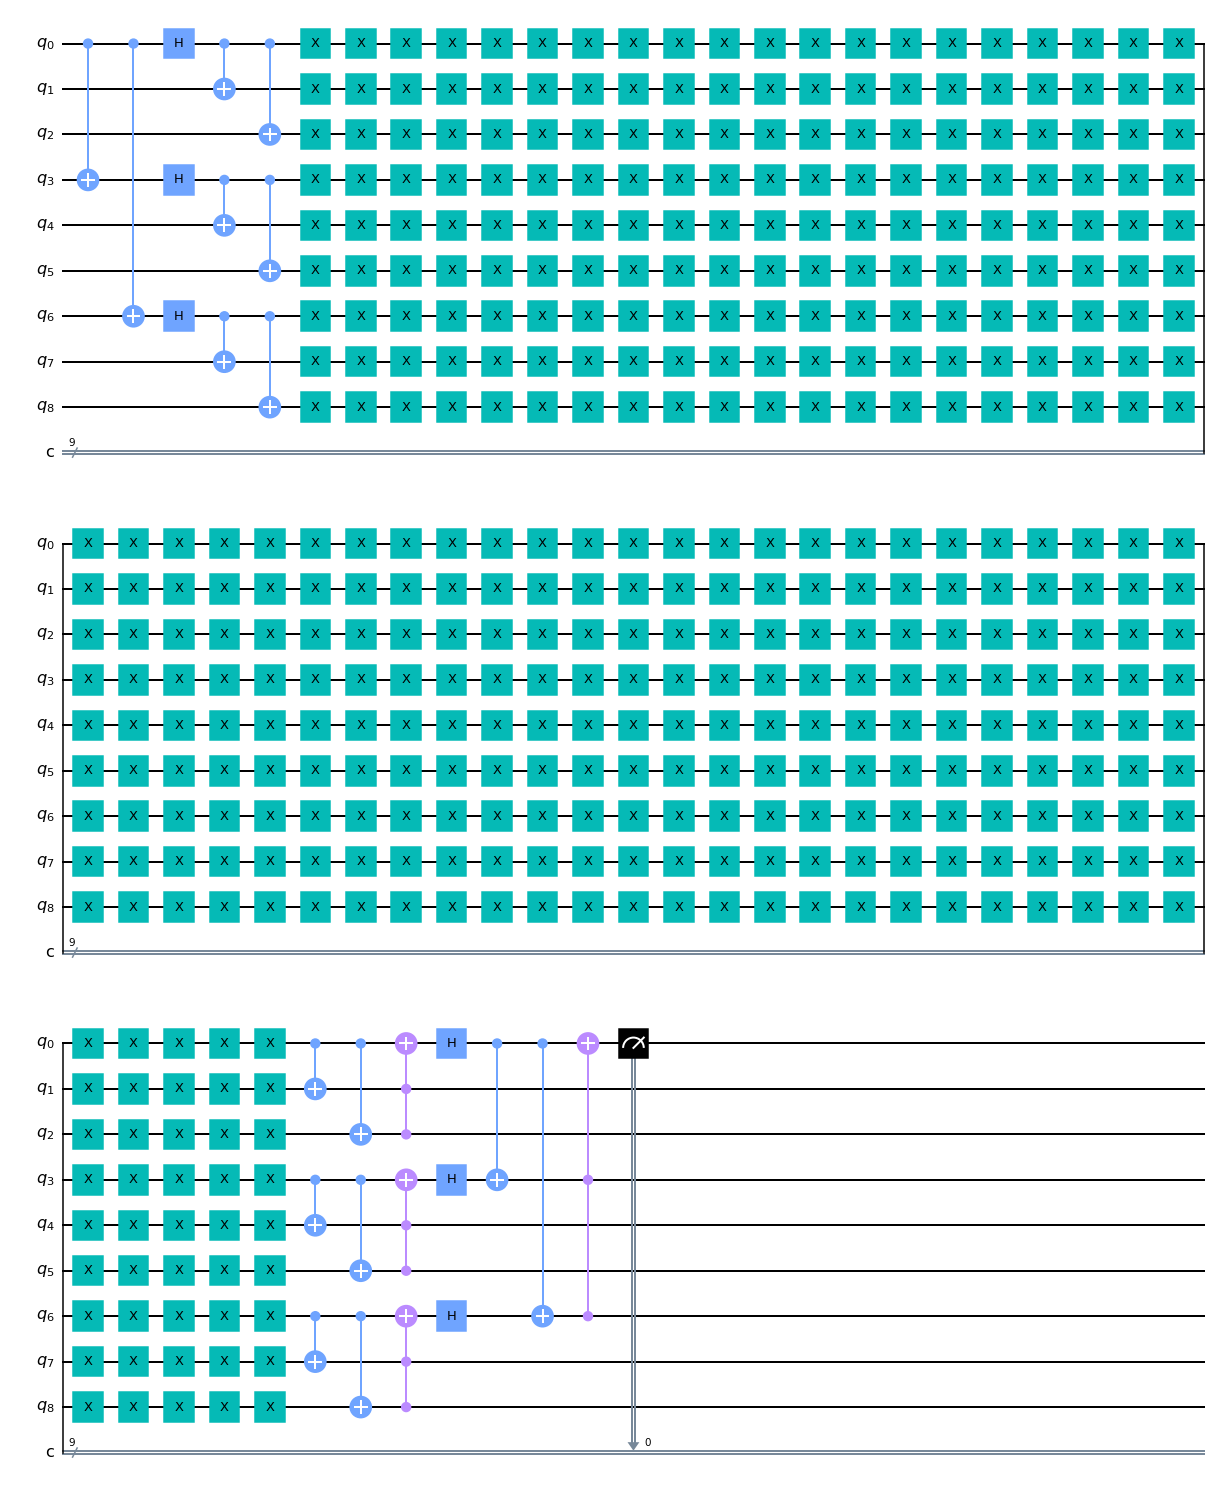

In [ ]:
ft_circuit.draw(output='mpl')

## Noise Model 

There are two possible forms of error: 

One is a gate error: an imperfection in any operation we perform. We model this here in a simple way, using so-called depolarizing noise. The effect of this will be to replace the state of any qubit with a completely random state. For two qubit gates, it is applied independently to each qubit. 

The other form of noise is that for measurement. This simply flips between a 0 to a 1 and vice-versa immediately before measurement. 
 

In [3]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
def get_noise(prob_1 = 0.01, prob_2=0.00, prob_3=0.0):

    # Depolarizing quantum errors
    error_1 = depolarizing_error(prob_1, 1)
    error_2 = depolarizing_error(prob_2, 2)
    error_3 = depolarizing_error(prob_3, 3)

    # Add errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['x']) # only bit flip has error
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    noise_model.add_all_qubit_quantum_error(error_3, ['ccx'])
    
    return noise_model

## Comparing the Circuits
* Shor's algorithm only corrects single qubit error's, so it's error rate is the probability of two or more qubits of the nine incurring an error
* This has to be less than the standard error rate for Shor's to be beneficial
* For bit-flips of depth 50, 0.002 gate error seems to be where the FT and nFT circuits perform similarly

### Run Simulation

In [4]:
from qiskit import BasicAer
def run(circuit_list, noise_model):
    data_list = []
    for circuit in circuit_list:
        backend = Aer.get_backend('aer_simulator')
        # circuit = transpile(circuit, backend)
        # print(circuit)
        job = backend.run(circuit, noise_model=noise_model)
        result = job.result()
        data_list.append(result.get_counts(circuit))
    errors = []
    for data in data_list:
        if '000000001' not in data:
            errors.append(0)
        else:
            tot = data['000000000'] + data['000000001']
            errors.append(data['000000001']/tot)
    return errors

In [5]:
print(get_noise(0.01))

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x']
  All-qubits errors: ['x']


In [8]:
runs = []
for i in range(15):
    runs.append(run([ft_circuit, nft_circuit], get_noise(0.0002905)))


NameError: name 'np' is not defined

In [9]:
import numpy as np
runs = np.array(runs)
print([np.sum(runs[:, 0])/15, np.sum(runs[:, 1])/15])

[0.0016927083333333334, 0.00703125]


In [ ]:
import numpy as np
errors = []

for noise in np.linspace(0, 0.01, 25): # 100 iterations
    runs = []
    for i in range(5):
        runs.append(run([ft_circuit, nft_circuit], get_noise(noise)))
    runs = np.array(runs)
    errors.append([np.sum(runs[:, 0])/5, np.sum(runs[:, 1])/5])
    print(errors[-1])

[0.0, 0.0]
[0.0015625, 0.0087890625]
[0.009375, 0.020703125]
[0.0208984375, 0.0275390625]
[0.0333984375, 0.04140625]
[0.0478515625, 0.0482421875]
[0.06953125, 0.0607421875]
[0.080859375, 0.0705078125]
[0.0953125, 0.0791015625]
[0.1265625, 0.0763671875]
[0.1361328125, 0.089453125]
[0.155859375, 0.09921875]
[0.1724609375, 0.105859375]
[0.1880859375, 0.1263671875]
[0.207421875, 0.1265625]
[0.2158203125, 0.1322265625]
[0.24140625, 0.1421875]
[0.255859375, 0.150390625]
[0.262109375, 0.1576171875]
[0.280078125, 0.1630859375]
[0.2876953125, 0.1767578125]
[0.2974609375, 0.1767578125]
[0.320703125, 0.183203125]
[0.3154296875, 0.185546875]
[0.3412109375, 0.1974609375]


In [ ]:
errors = np.array(errors)

ft_errors = errors[:, 0]
nft_errors = errors[:, 1]

(<matplotlib.lines.Line2D at 0x7fd2e0b2e490>,
 [<matplotlib.lines.Line2D at 0x7fd2e18cff10>])

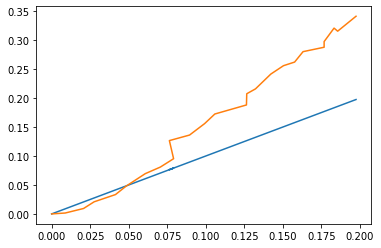

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
line, = ax.plot(nft_errors, nft_errors)
line, ax.plot(nft_errors, ft_errors)


(<matplotlib.lines.Line2D at 0x7fd2e1975110>,
 [<matplotlib.lines.Line2D at 0x7fd2e1975350>])

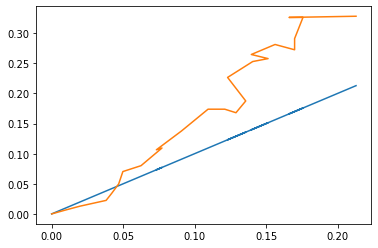

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
line, = ax.plot(nft_errors, nft_errors)
line, ax.plot(nft_errors, ft_errors)


With an X-gate error rate of 0.002, the overall single-qubit error rate is around 0.05 (52/1024), which is around 25x times higher. 

### Predict Error Rates
$p$ is the probability of one qubit experiencing an error. This is **NOT** the equal to the probability in the noise model, which is the probability that a gate creates an error. A circuit with more gates and the same noise model will have a higher $p$. 

In [ ]:
factorials = [1]
choose = [] # choose[i] = 9 choose i

for i in range(1, 10):
    factorials.append(factorials[-1]*i)

for i in range(10):
    choose.append(factorials[9]/(factorials[9-i]*factorials[i]))
    
def calc_probs(error):
    pows1 = [1]
    pows2 = [1]
    for i in range(1, 10):
        pows1.append(pows1[-1]*error);
        pows2.append(pows2[-1]*(1-error))
    
    p = [] # prob that first i are not correct, rest are
    for i in range(10): 
        p.append(pows1[i]*pows2[9-i])
    p2 = 0 #probabilities >1 errors
    for i in range(2, 10):
        p2+=p[i]*choose[i]
    
    return error, p2
    
calc_probs(0.03)

(0.03, 0.028158234297256834)

In [ ]:
pow(0.05, 2)*pow(0.95, 7)*36

0.0628503566484375

0
0.0322999999999999


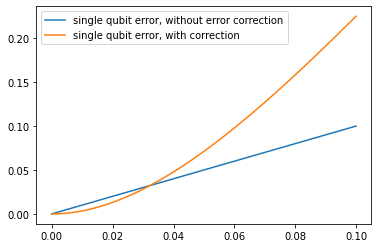

In [ ]:
import matplotlib.pyplot as plt
p1 = []
p2 = []

errors = []
e = 0
d = 0.0001
while e < 0.1:
    errors.append(e)
    a, b = calc_probs(e)
    p1.append(a)
    p2.append(b)
    #print(e, a, b)
    if abs(a-b) < 0.00001:
        print(e)
    e+=d
fig = plt.figure()
ax = plt.axes()
line = ax.plot(errors, p1, label='single qubit error, without error correction')
line = ax.plot(errors, p2,  label='single qubit error, with correction') #0.14 is when single qubit errors prevail - ft circuit works better
plt.legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c782e670-8153-4fc7-a9a3-0ae2dddfa952' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>